# 2. Classification

In [19]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.activations import relu, selu
from tensorflow.keras.layers import Activation, LeakyReLU, PReLU
from tensorflow.keras.backend import clear_session

### Supervised learning

- What is supervised learning?
- Training
- Fitting
- Labels
- Error / cost / objective functions

### Classification

Clasification is a type of 

- What is classification?
- Different approaches
  - Logistic regression - log loss
  - ANNs, SVMs
  - ...

### No free lunch

- Model selection.
- Parametric / nonparametric models.
- Discriminative / generative modelling.

A model is a simplified replica of the real world. This allows us to build and understand them with relative ease and use them to make predictions of future events. However these simplifations abstract away details, meaning the model cannot be a full representation of the real world and will therefore make mistakes. The abstraction level of your model creates a trade-off between performance and accuracy.

No free lunch theorum states that no model is guarenteed to work for all problems, all you can do is test and evaluate each to find a best solution.

### Overfitting

As a model is a abstraction, so are the patterns within it. It is easy to create a model to fit to data, with little effort you could create a model which accuratly predicts the training data's labels given the features. You could imagine this as creating a giant look-up table; when a training instance is given to the model it finds that combination of features in the table and returns the related label.

But what happens when a new set of features are given to the model it hasn't seen before? It wont have the exact result for the data and so it will make a wrong prediction. This phenomona of a model learning too well from the data it was trained on is called overfitting. This happens when the model learns the pattern in your abstraction rather than the pattern of the real problem. 

The aim is to build a model which generalises to the problem you are trying to solve. This way you can make predictions on unseen data and see the same results as you did whilst training.

### Training, testing and validation

Model training is the process of learning from data. In supervised learning we have labeled data and so we have a target to aim for. Data is given to the model and slowly it learns in different ways how to tune itself to reproduce the correct labels when given that data.

As discussed above it is not enough to predict the data it has learned from. To evaluate a model's real-world performance a model must be tested on 

### Cross-validation

- explain cross validation

### Optimisation

- Hyperparameters

## Classification with MNIST

- The aim of classification with MNIST
- Get the data
- Recap analysis
  - Size, shape, type
  - Features
  - Missing data, outliers etc.
  - Target feature of dataset (class)

Download the MNIST dataset, getting features X and labels y:

In [2]:
X, y = fetch_openml('mnist_784', return_X_y=True)

We shall look at the number of unique features in the dataset.

In [3]:
n_classes = len(np.unique(y))
print(n_classes)

10


There appear to be 10 unique digit types.

We shall put the data into a NumPy array and analyse the shape of the data:

In [4]:
X = np.asarray(X)
y = np.asarray(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Image shape: {X[0].shape}")

X shape: (70000, 784), y shape: (70000,)
Image shape: (784,)


From the shape we can see that we have the full MNIST dataset of 70000 hand written didgets. 

They are yet to be split into a training and testing set and each image has been flattened to a (784,) array rather than the standard (28,28) form.

Now we shall have a look at the image data to see what form it is in.

In [5]:
print(np.min(X[0]), np.max(X[0]))

0.0 255.0


Looking at the minimum and maximum values in appears that pixel are of the standard 0-255 intensity form. 

It is beneficial to some machine learning methods for values to be normalised between 0-1, notably neural networks so we shall do this in the data preparation step.

Finally we shall check the datatypes for features and labels.

In [6]:
print(X.dtype)
print(y.dtype)

float64
object


The features are of float type as expected but it may be beneficial to convert the string type labels to integers.

#### Preparing the data

  - train, val test sets
  - cross validation
  - reshape / retype

As stated earlier normalising the feature values will be beneficial for machine learning later on.

In [7]:
X_full = X / 255.0
print(np.min(X_full), np.max(X_full))

0.0 1.0


We shall also now convert the string type features to integers for use later on.

In [8]:
y_full = y.astype('int64')
print(y.dtype)

object


We will need to create a train, validation and test set before we proceed using sklearns `train_test_split`.

In [9]:
# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)

# remove a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [10]:
print(X_full.shape[0])
print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

70000
44800
11200
14000


Now we can train the data and analyse using the validation set before testing on the test set. This will allow us to minimise overfitting by ensuring our model generalises well.

Later on we shall use cross-validation on the entire training set to ensure maximum generalisation, but for now we shall use the the validation set for this.

## 2.1 Artificial Neural Networks (ANNs)

### Classifying MNIST

Discuss validation / training results

#### Analysing model training

We shall use Tensorboard to visualise our model results as well as analyse training.

We shall configure it to create a new subdirectory for each model instance.

In [18]:
def get_tb_dir(name):
    curr_dir = os.path.join(os.curdir, "tensorboard_logs")
    tb_dir = time.strftime("{}_model_%Y_%m_%d-%H-%M-%S".format(name))
    return os.path.join(curr_dir, tb_dir)

Now we can create a callback during model training for Tensorboard

In [19]:
tensorboard = TensorBoard(get_tb_dir("base"))

Fitting the model with the callback will then write the logs to it's own directory in `tensorboard_logs`.

In [20]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=[784]))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard])

Epoch 1/10
1400/1400 [==============================] - 4s 2ms/step - loss: 1.2350 - accuracy: 0.6550 - val_loss: 0.3782 - val_accuracy: 0.8952
Epoch 2/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.3323 - accuracy: 0.9084 - val_loss: 0.3063 - val_accuracy: 0.9127
Epoch 3/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2687 - accuracy: 0.9235 - val_loss: 0.2719 - val_accuracy: 0.9234
Epoch 4/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2383 - accuracy: 0.9340 - val_loss: 0.2465 - val_accuracy: 0.9273
Epoch 5/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.2090 - accuracy: 0.9418 - val_loss: 0.2280 - val_accuracy: 0.9334
Epoch 6/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1911 - accuracy: 0.9449 - val_loss: 0.2107 - val_accuracy: 0.9375
Epoch 7/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1762 - accuracy: 0.9501 - val_loss: 0.1997 - val_accuracy:

Now we can look at the Tensorboard logs in `/tensorboard_logs`

In [21]:
model.evaluate(X_test, y_test)

438/438 [==============================] - 1s 2ms/step - loss: 0.1676 - accuracy: 0.9511


[0.1676267385482788, 0.9511428475379944]

### Learning rate

I shall create a Keras wrapper in order to use Scikit's grid search to analyse learning rate changes.

With this wrapper we can search for params: 
- `kernel_initializer`: weigh and bias initialisation method
- `optimizer`: optimisation method used in back progogation
- `activation`: activation function used in forward pass
- `lr`: learning rate of the optimiser
- `momentum`: momentum of the optimiser

In [ ]:
def create_lr_model(lr):
    model = Sequential()
    model.add(Dense(100, activation="relu", input_shape=[784]))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer='sgd', metrics=["accuracy"])

In [ ]:
np.random.seed(42)
lr_model = KerasClassifier(build_fn=create_model, epochs=10)
param_grid = {"lr": [1, 0.1, 0.01, 0.001, 0.0001]}

# grid search
lr_grid = GridSearchCV(act_model, param_grid, cv=2, verbose=0)
lr_grid_results = act_grid.fit(X_train, y_train,
                               validation_data=[X_val, y_val],
                               callbacks=[TensorBoard(get_tb_dir("learning_rate"))],
                               verbose=0)

- learning rate scheduling model

### Vanishing / exploding gradient problem

- What is the vanishing gradient problem

## 2.2. Support Vector Machines (SVMs)

Train an SVM (with a chosen Kernel) and perform the same analyses as for ANNs. Interpret  and  discuss  your  results. Does the model overfit? How do they compare with ANNs? And why? How does the type of kernel (e.g.linear, RBF, etc.) impact on performance?

### Linear SVM

Grid search soft-margin (C) parameter.

In [22]:
grid_linear_svm = LinearSVC(loss="squared_hinge", dual=False,
                            max_iter=1000)

c_params = {"C": [0.01, 0.1, 1, 10, 10]}

c_gridsearch = GridSearchCV(grid_linear_svm, c_params,
                            cv=2, verbose=3)

In [23]:
c_gridsearch.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.903, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.904, total=   1.7s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.898, total=   2.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.903, total=   2.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.883, total=   3.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.887, total=   3.5s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.866, total=   7.2s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.868, total=   8.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.866, total=   7.2s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.3s finished


GridSearchCV(cv=2, estimator=LinearSVC(dual=False),
             param_grid={'C': [0.01, 0.1, 1, 10, 10]}, verbose=3)

In [24]:
c_gridsearch.best_params_

{'C': 0.01}

In [26]:
c_gridsearch.best_score_

0.9035978835978836

### Polynomial KSVM

In [27]:
poly_params = {"degree": [2, 3]}
grid_poly = SVC(kernel='poly', max_iter=1000)
poly_gridsearch = GridSearchCV(grid_poly, poly_params, cv=2)

In [28]:
poly_gridsearch.fit(X_train, y_train)

/home/kai/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=2, estimator=SVC(kernel='poly', max_iter=1000),
             param_grid={'degree': [2, 3]})

In [29]:
poly_gridsearch.best_params_

{'degree': 2}

In [31]:
poly_gridsearch.best_score_

0.9544973544973545

It appears the 2nd degree polynomial kernel is a good fit, a 5% increase over the standard polynomial kernel.

### Radial basis function (RBF) KSVM

In [34]:
rbf_params = {"gamma": [1, 5, 'scale', 'auto']}
grid_rbf = SVC(kernel='rbf', max_iter=5000)
rbf_gridsearch = GridSearchCV(grid_rbf, rbf_params, cv=2)

In [35]:
rbf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(max_iter=5000),
             param_grid={'gamma': [1, 5, 'scale', 'auto']})

In [36]:
rbf_gridsearch.best_params_

{'gamma': 'scale'}

In [38]:
rbf_gridsearch.best_score_

0.9579365079365079

### Sigmoid KSVM

In [46]:
sigmoid_params = {"gamma": [1, 5, 10, 'scale', 'auto']}
grid_sigmoid = SVC(kernel='sigmoid', max_iter=5000)
sigmoid_gridsearch = GridSearchCV(grid_sigmoid, sigmoid_params, cv=2)

In [47]:
sigmoid_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(kernel='sigmoid', max_iter=5000),
             param_grid={'gamma': [1, 5, 10, 'scale', 'auto']})

In [48]:
sigmoid_gridsearch.best_params_

{'gamma': 'auto'}

In [50]:
sigmoid_gridsearch.best_score_

0.9051851851851852

### Analysis of kernels

In [35]:
linear_svm = SVC(kernel="linear").fit(X_train, y_train)
poly_svm = SVC(kernel="poly", max_iter=5000, degree=2).fit(X_train, y_train)
rbf_svm = SVC(kernel="rbf", max_iter=5000, gamma="scale").fit(X_train, y_train)
sigmoid_svm = SVC(kernel="sigmoid", max_iter=5000, gamma="auto").fit(X_train, y_train)

svms = [
    ("linear", linear_svm),
    ("polynomial", poly_svm),
    ("rbf", rbf_svm),
    ("sigmoid", sigmoid_svm),
]

In [36]:
for (name, svm) in svms:
    print(f"{name} kernel: {svm.score(X_test, y_test)}")

linear kernel: 0.9312142857142857
polynomial kernel: 0.9713571428571428
rbf kernel: 0.9751428571428571
sigmoid kernel: 0.9242857142857143


## Compairson of Methods

- svm on pca(2)
- sklearn nn on pca(2)
- compare decision boundaries
- discuss pros and cons of each

In [117]:
pca = PCA(n_components=2)
mm = MinMaxScaler()

X, y = mm.fit_transform(pca.fit_transform(X_train)), y_train
sample_X, _, sample_y, _ = train_test_split(X, y, test_size=0.97, stratify=y)

In [118]:
nn = MLPClassifier(
    max_iter=1000, 
    early_stopping=True,
).fit(sample_X, sample_y)

In [119]:
svm = SVC(
    kernel="rbf",  
    max_iter=10000
).fit(sample_X, sample_y)

In [120]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
    
x, y = sample_X[:, 0], sample_X[:, 1]
xx, yy = make_meshgrid(x, y)

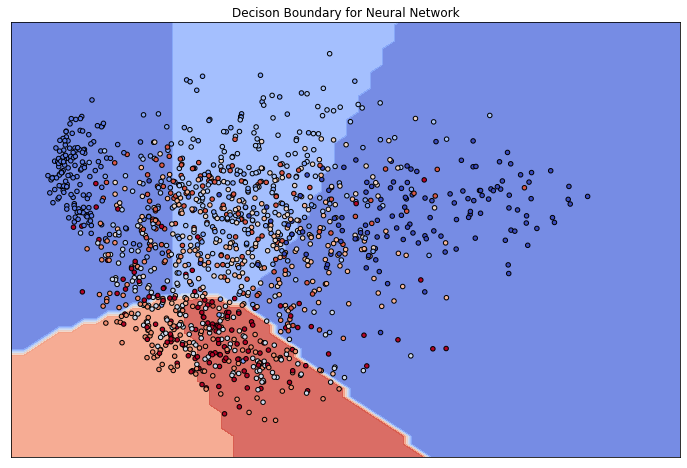

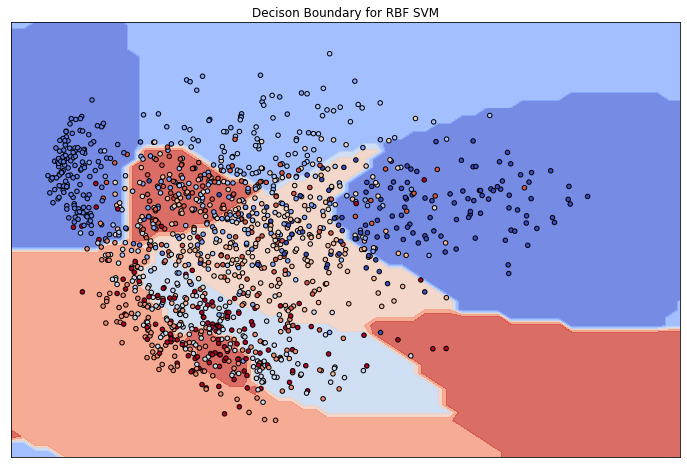

In [122]:
for (name, clf) in [("Neural Network", nn), ("RBF SVM", svm)]:
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title('Decison Boundary for {}'.format(name))
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(x, y, c=sample_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=1)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks([])
    ax.set_yticks([])